**This notebook focuses on the effectiveness of Total Variance Minimization against adversarial attacks on the MNIST and MARVEL datasets.**

## **Section 0 - Setting Up**

### **Load prerequisites**

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout, Layer

from keras_radam import RAdam

import cv2
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from art import config
from art.attacks.evasion import FastGradientMethod, DeepFool, ProjectedGradientDescent, SaliencyMapMethod, CarliniL2Method, NewtonFool, BasicIterativeMethod
from art.defences.preprocessor import TotalVarMin
from art.defences.trainer import AdversarialTrainer
from art.estimators.classification import KerasClassifier, TensorFlowV2Classifier
from art.utils import load_mnist

### **Modification: Disabling eager execution to enable adversarial crafting**

In [2]:
tf.compat.v1.disable_eager_execution()

### **Load MARVEL dataset**

In [23]:
x_train = []
y_train = []
x_test_cln = []
y_test_cln = [] 
min_pixel_value = 0
max_pixel_value = 1

def marvel_class(filename):
    switcher={
        'HeavyLoadCarrier': [1,0,0,0,0,0,0,0,0],
        'CombatVessel': [0,1,0,0,0,0,0,0,0],
        'ContainerShip': [0,0,1,0,0,0,0,0,0],
        'PassengersShip': [0,0,0,1,0,0,0,0,0],
        'Ro-roCargo': [0,0,0,0,1,0,0,0,0],
        'Tanker': [0,0,0,0,0,1,0,0,0],
        'Tug': [0,0,0,0,0,0,1,0,0],
        'SupplyVessel': [0,0,0,0,0,0,0,1,0],
        'Yacht': [0,0,0,0,0,0,0,0,1]
    }
    return switcher.get(filename)

def load_training_data(filename):
    url = "/home/cyber/Desktop/Adrian/marvel_data/train_9/"+filename
    for imgname in os.listdir(url):
        img = cv2.imread(os.path.join(url,imgname))
        if img is not None:
            img = cv2.resize(img, (320,240))
            x_train_cln.append(img/255)
            y_train_cln.append(marvel_class(filename))
            i = i+1
        if i == 100:
            break
    return x_train_cln, y_train_cln

def load_test_data(filename):
    url = "/home/cyber/Desktop/Adrian/marvel_data/test_9/"+filename
    i = 0
    for imgname in os.listdir(url):
        img = cv2.imread(os.path.join(url,imgname))
        if img is not None:
            img = cv2.resize(img, (320,240))
            x_test_cln.append(img/255)
            y_test_cln.append(marvel_class(filename))
            i = i + 1
        if i == 100:
            break
    return x_test_cln, y_test_cln

# for filename in os.listdir("/home/cyber/Desktop/Adrian/marvel_data/train_9"):
#     load_training_data(filename)
#     print(filename)

for filename in os.listdir("/home/cyber/Desktop/Adrian/marvel_data/test_9"):
    load_test_data(filename)
    print(filename)
    
#load_training_data("/home/cyber/Desktop/Adrian/marvel_data/test_9/CombatVessel")


CombatVessel
Yacht
Ro-roCargo
ContainerShip
PassengersShip
Tanker
HeavyLoadCarrier
SupplyVessel
Tug


*Modification: Convert MARVEL x_test/x_train from uint8 into float32, to enable classification*

In [24]:
x_test_cln = np.array(x_test_cln, dtype=np.float32)

### **Load MNIST dataset**

In [3]:
(x_train_cln, y_train_cln), (x_test_cln, y_test_cln), min_pixel_value, max_pixel_value = load_mnist()
# x_test_cln, y_test_cln = x_test_cln[:50], y_test_cln[:50]

### **Load / Create classifier model**

*MNIST pre-trained model*

In [4]:
model = load_model("/home/cyber/mnist_trained_model.h5")

*MARVEL pre-trained model*

In [25]:
model_path = "/home/cyber/Desktop/Adrian/Xception-10-0.74.hdf5"
model = load_model(model_path, custom_objects={'RAdam': RAdam}, compile=False)

*Optional step: Train and save a model for future use*

In [5]:
# model.fit(x_train_cln, y_train_cln, batch_size=64, epochs=10, verbose=True)

In [6]:
# model.save("/home/cyber/dataset_trained_model.h5")

*Create ART classifier*

In [7]:
classifier = KerasClassifier(model=model, clip_values=(min_pixel_value, max_pixel_value), use_logits=False)

## **Section 1 - Attack**

Step 1: Evaluate the classifier on benign test examples

In [8]:
predictions_cln = classifier.predict(x_test_cln)
accuracy_cln = np.sum(np.argmax(predictions_cln, axis=1) == np.argmax(y_test_cln, axis=1)) / len(y_test_cln)

print("Accuracy on benign test examples: {}%".format(accuracy_cln * 100))

/home/cyber/miniconda3/envs/tf-gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Accuracy on benign test examples: 99.11%


Step 2: Split benign test examples into true and false positives

In [9]:
tp_cln_indexes=[]
fp_cln_indexes=[]
x_test_cln_tp=[]
y_test_cln_tp=[]
x_test_cln_fp=[]
y_test_cln_fp=[]

for k in range(len(predictions_cln)):
    if(np.argmax(predictions_cln, axis=1)[k] == np.argmax(y_test_cln, axis=1)[k]):
        tp_cln_indexes.append(k)
    else:
        fp_cln_indexes.append(k)

for k in tp_cln_indexes:
    x_test_cln_tp.append(x_test_cln[k])
    y_test_cln_tp.append(y_test_cln[k])
    
for k in fp_cln_indexes:
    x_test_cln_fp.append(x_test_cln[k])
    y_test_cln_fp.append(y_test_cln[k])
    
x_test_cln_tp = np.array(x_test_cln_tp)
x_test_cln_fp = np.array(x_test_cln_fp)

print('Number of benign true positives: {:}'.format(len(x_test_cln_tp)))
print('Number of benign false positives: {:}'.format(len(x_test_cln_fp)))

Number of benign true positives: 9911
Number of benign false positives: 89


Step 3: Craft adversarial examples

*Jacobian-based Saliency Map Attack (JSMA)*

In [8]:
# adv_crafter = SaliencyMapMethod(classifier=classifier, theta = 0.1, gamma=0.3, verbose=True)
# x_test_JSMA_MARVEL = adv_crafter.generate(x_test_cln)
# %store x_test_JSMA_MARVEL

In [9]:
# adv_crafter = SaliencyMapMethod(classifier=classifier, theta = 0.1, gamma=0.3, verbose=True)
# x_test_JSMA_MNIST = adv_crafter.generate(x_test_cln)
# %store x_test_JSMA_MNIST

*Basic Iterative Method (BMI)*

In [10]:
# adv_crafter = BasicIterativeMethod(classifier, eps=0.3, eps_step=0.1, max_iter=50)
# x_test_BIM_MARVEL = adv_crafter.generate(x_test_cln)
# %store x_test_BIM_MARVEL

In [11]:
# adv_crafter = BasicIterativeMethod(classifier, eps=0.3, eps_step=0.1, max_iter=50)
# x_test_BIM_MNIST = adv_crafter.generate(x_test_cln)
# %store x_test_BIM_MNSIT

*Projected Gradient Descent (PGD)*

In [12]:
# adv_crafter = ProjectedGradientDescent(classifier, eps=0.3, eps_step=0.1, max_iter=100)
# x_test_PGD_MARVEL = adv_crafter.generate(x_test_cln)
# %store x_test_PGD_MARVEL

In [13]:
# adv_crafter = ProjectedGradientDescent(classifier, eps=0.3, eps_step=0.1, max_iter=100)
# x_test_PGD_MNIST = adv_crafter.generate(x_test_cln)
# %store x_test_PGD_MNIST

*NewtonFool*

In [14]:
# adv_crafter =  NewtonFool(classifier=classifier, eta=0.01, max_iter=100, verbose=True)
# x_test_Newton_MARVEL = adv_crafter.generate(x_test_cln)
# %store x_test_Newton_MARVEL

In [10]:
# adv_crafter =  NewtonFool(classifier=classifier, eta=0.3, max_iter=100, verbose=True)
# x_test_Newton_MNIST = adv_crafter.generate(x_test_cln)
# %store x_test_Newton_MNIST

*DeepFool*

In [11]:
# adv_crafter = DeepFool(classifier=classifier, epsilon=1e-06, max_iter=100)
# x_test_Deep_MARVEL = adv_crafter.generate(x_test_cln)
# %store x_test_Deep_MARVEL

In [12]:
# adv_crafter = DeepFool(classifier=classifier, epsilon=1e-06, max_iter=100)
# x_test_Deep_MNIST = adv_crafter.generate(x_test_cln)
# %store x_test_Deep_MNIST

*Adversarial Examples*

In [65]:
attack_name = 'DeepFool'
dataset = 'MNIST'
%store -r x_test_Deep_MNIST
x_test_adv = x_test_Deep_MNIST

Step 4: Evaluate the classifier on the adversarial test set

In [66]:
predictions_adv = classifier.predict(x_test_adv)
accuracy_adv = np.sum(np.argmax(predictions_adv, axis=1) == np.argmax(y_test_cln, axis=1)) / len(y_test_cln)

print("Accuracy on adversarial test examples: {}%".format(accuracy_adv * 100))

Accuracy on adversarial test examples: 6.61%


Step 5: Split the adversarial test examples into true and false positives

In [67]:
tp_adv_indexes=[]
fp_adv_indexes=[]
x_test_adv_tp=[]
y_test_adv_tp=[]
x_test_adv_fp=[]
y_test_adv_fp=[]

for k in range(len(predictions_adv)):
    if(np.argmax(predictions_adv, axis=1)[k] == np.argmax(y_test_cln, axis=1)[k]):
        tp_adv_indexes.append(k)
    else:
        fp_adv_indexes.append(k)

for k in tp_adv_indexes:
    x_test_adv_tp.append(x_test_adv[k])
    y_test_adv_tp.append(y_test_cln[k])
    
for k in fp_adv_indexes:
    x_test_adv_fp.append(x_test_adv[k])
    y_test_adv_fp.append(y_test_cln[k])
    
x_test_adv_tp = np.array(x_test_adv_tp)
x_test_adv_fp = np.array(x_test_adv_fp)

print('Adversarial TP: {:}'.format(len(x_test_adv_tp)))
print('Adversarial FP: {:}'.format(len(x_test_adv_fp)))

Adversarial TP: 661
Adversarial FP: 9339


Optional step: Plot benign samples and their adversarial counterparts

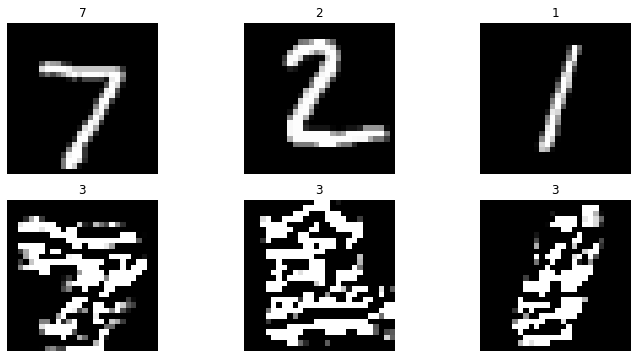

In [68]:
#plot images
plt.figure(figsize=(10, 10))
num = 3

for i in range(num):
    ax = plt.subplot(4, num, i + 1)
    plt.imshow(x_test_cln[i], cmap='gray')
    ax.set_title('{:}'.format(np.argmax(y_test_cln,axis=1)[i]))
    plt.axis("off")
    
    ax = plt.subplot(4, num, i + num + 1)
    plt.imshow(x_test_adv[i], cmap='gray')
    ax.set_title('{:}'.format(np.argmax(predictions_adv,axis=1)[i]))
    plt.axis("off")
    
plt.tight_layout()
plt.show()

## **Section 2 - Defence**

### **Total Variance Minimization**

Step 1: Transform input

In [69]:
defence = TotalVarMin(verbose=True)

In [70]:
x_test_cln_tvm = defence(x_test_cln*255)[0] / 255
x_test_cln_tp_tvm = defence(x_test_cln_tp * 255)[0] / 255
x_test_cln_fp_tvm = defence(x_test_cln_fp * 255)[0] / 255

Variance minimization:   0%|          | 0/10000 [00:00<?, ?it/s]

Variance minimization:   0%|          | 0/9911 [00:00<?, ?it/s]

Variance minimization:   0%|          | 0/89 [00:00<?, ?it/s]

In [71]:
x_test_adv_tvm = defence(x_test_adv*255)[0] / 255
x_test_adv_tp_tvm = defence(x_test_adv_tp * 255)[0] / 255
x_test_adv_fp_tvm = defence(x_test_adv_fp * 255)[0] / 255

Variance minimization:   0%|          | 0/10000 [00:00<?, ?it/s]

Variance minimization:   0%|          | 0/661 [00:00<?, ?it/s]

Variance minimization:   0%|          | 0/9339 [00:00<?, ?it/s]

Step 2: Evaluate the classifier on all 4 sets of data after PixelDefend

In [72]:
predictions_cln_tvm = classifier.predict(x_test_cln_tvm)
accuracy_cln_tvm = np.sum(np.argmax(predictions_cln_tvm, axis=1) == np.argmax(y_test_cln, axis=1)) / len(y_test_cln)

print("Effect of TotalVarMin on entire benign test set: {:.2f}%".format((accuracy_cln_tvm - accuracy_cln) * 100))
 
predictions_cln_tp_tvm = classifier.predict(x_test_cln_tp_tvm)
accuracy_cln_tp_tvm = np.sum(np.argmax(predictions_cln_tp_tvm, axis=1) == np.argmax(y_test_cln_tp, axis=1)) / len(y_test_cln_tp)

# print("\nAccuracy on true positive benign test examples after TotalVarMin: {:.2f}%".format(accuracy_cln_tp_tvm * 100))
print("\nAccuracy drop on true positive benign test examples after TotalVarMin: {:.2f}%".format((1 - accuracy_cln_tp_tvm) * 100))

predictions_cln_fp_tvm = classifier.predict(x_test_cln_fp_tvm)
accuracy_cln_fp_tvm = np.sum(np.argmax(predictions_cln_fp_tvm, axis=1) == np.argmax(y_test_cln_fp, axis=1)) / len(y_test_cln_fp)

print("\nAccuracy increase on false positive benign test examples after TotalVarMin: {:.2f}%".format(accuracy_cln_fp_tvm * 100))

predictions_adv_tvm = classifier.predict(x_test_adv_tvm)
accuracy_adv_tvm = np.sum(np.argmax(predictions_adv_tvm, axis=1) == np.argmax(y_test_cln, axis=1)) / len(y_test_cln)

print("\nEffect of TotalVarMin on entire adversarial test set: {:.2f}%".format((accuracy_adv_tvm-accuracy_adv) * 100))

predictions_adv_tp_tvm = classifier.predict(x_test_adv_tp_tvm)
accuracy_adv_tp_tvm = np.sum(np.argmax(predictions_adv_tp_tvm, axis=1) == np.argmax(y_test_adv_tp, axis=1)) / len(y_test_adv_tp)

# print("\nAccuracy on true positive adversarial test examples after TotalVarMin: {:.2f}%".format(accuracy_adv_tp_tvm * 100))
print("\nAccuracy drop on true positive adversarial test examples after TotalVarMin: {:.2f}%".format((1 - accuracy_adv_tp_tvm) * 100))

predictions_adv_fp_tvm = classifier.predict(x_test_adv_fp_tvm)
accuracy_adv_fp_tvm = np.sum(np.argmax(predictions_adv_fp_tvm, axis=1) == np.argmax(y_test_adv_fp, axis=1)) / len(y_test_adv_fp)

print("\nAccuracy increase on false positive adversarial test examples after TotalVarMin: {:.2f}%".format(accuracy_adv_fp_tvm * 100))

Effect of TotalVarMin on entire benign test set: -17.04%

Accuracy drop on true positive benign test examples after TotalVarMin: 17.82%

Accuracy increase on false positive benign test examples after TotalVarMin: 19.10%

Effect of TotalVarMin on entire adversarial test set: 15.30%

Accuracy drop on true positive adversarial test examples after TotalVarMin: 76.85%

Accuracy increase on false positive adversarial test examples after TotalVarMin: 21.63%


Optional step: Plot all data pre- and post-transformation

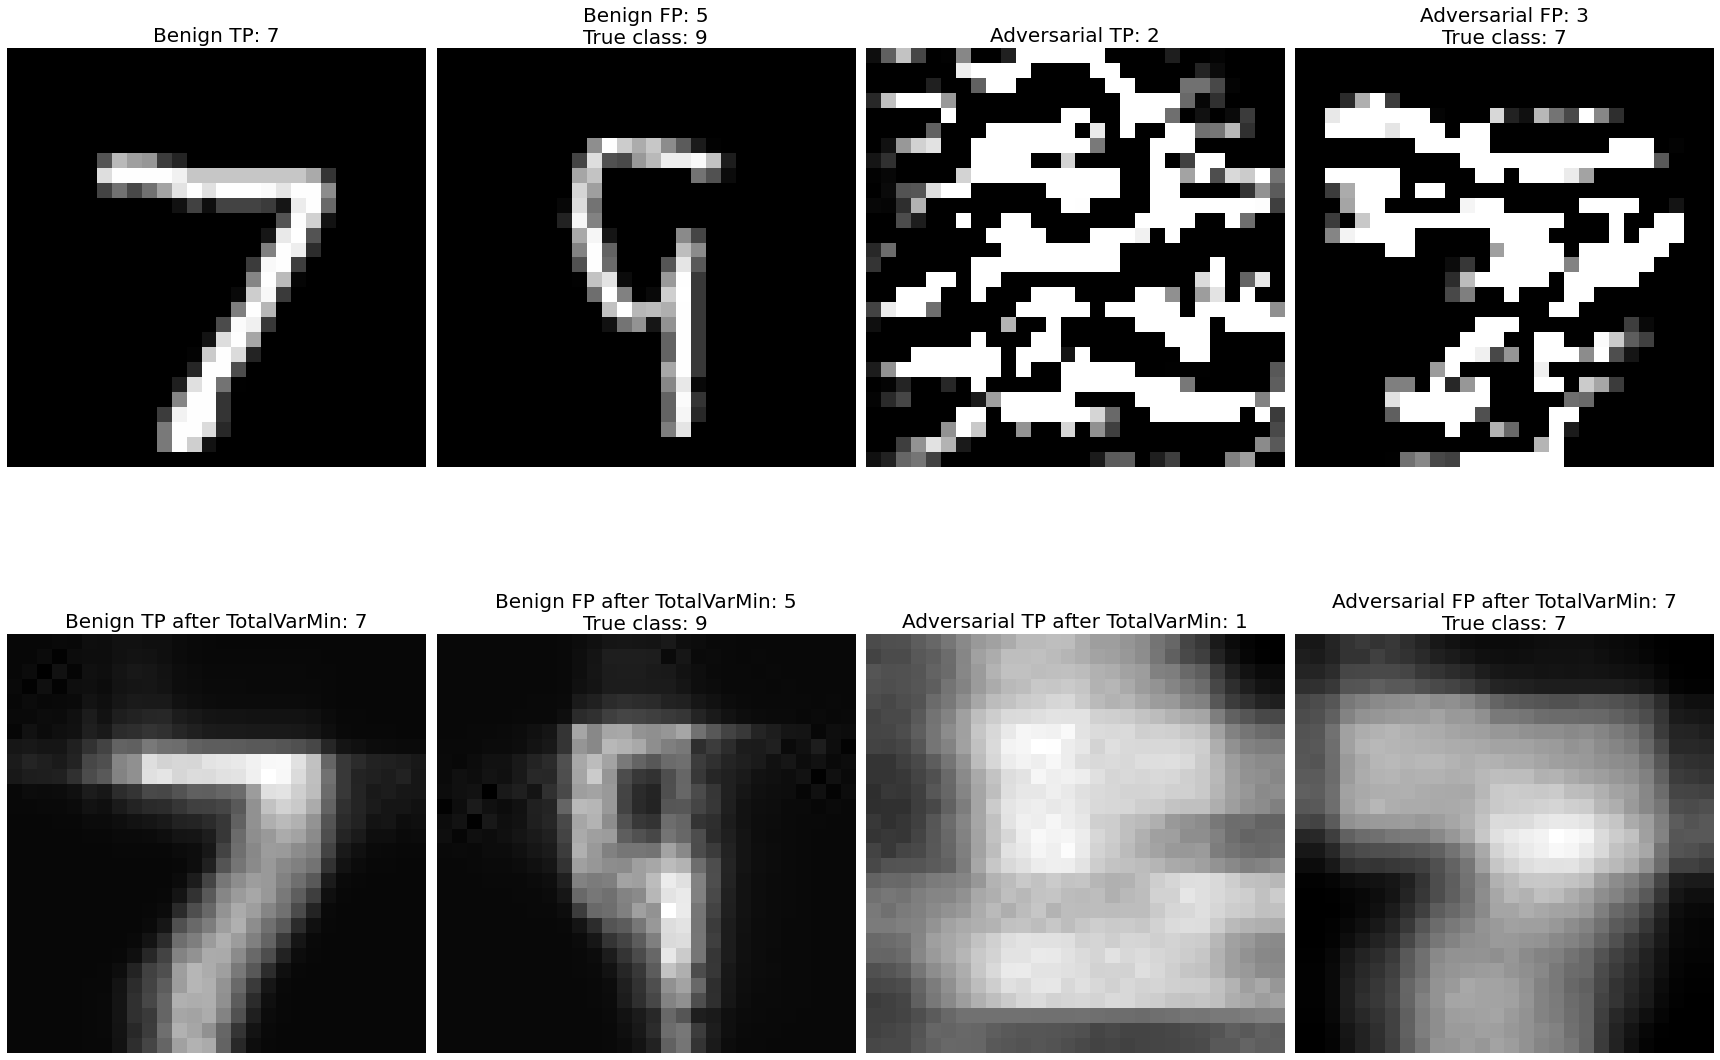

In [73]:
#plot images
predictions_cln_tp = classifier.predict(x_test_cln_tp)
predictions_cln_fp = classifier.predict(x_test_cln_fp)
predictions_adv_tp = classifier.predict(x_test_adv_tp)
predictions_adv_fp = classifier.predict(x_test_adv_fp)

plt.figure(figsize=(24,18))

#Plot benign true positives
ax = plt.subplot(2, 4, 1)
plt.imshow(x_test_cln_tp[0], cmap='gray')
ax.set_title('Benign TP: {:}'.format(np.argmax(predictions_cln_tp,axis=1)[0]), fontsize=20, loc='center', wrap=True)
plt.axis("off")

ax = plt.subplot(2, 4, 1+4)
plt.imshow(x_test_cln_tp_tvm[0], cmap='gray')
ax.set_title('Benign TP after TotalVarMin: {:}'.format(np.argmax(predictions_cln_tp_tvm,axis=1)[0]), fontsize=20, loc='center', wrap=True)
plt.axis("off")

#Plot benign false positives
ax = plt.subplot(2, 4, 2)
plt.imshow(x_test_cln_fp[0], cmap='gray')
ax.set_title('Benign FP: {:}\nTrue class: {:}'.format(np.argmax(predictions_cln_fp,axis=1)[0], np.argmax(y_test_cln_fp,axis=1)[0]), fontsize=20, loc='center', wrap=True)
plt.axis("off")

ax = plt.subplot(2, 4, 2+4)
plt.imshow(x_test_cln_fp_tvm[0], cmap='gray')
ax.set_title('Benign FP after TotalVarMin: {:}\nTrue class: {:}'.format(np.argmax(predictions_cln_fp_tvm,axis=1)[0], np.argmax(y_test_cln_fp,axis=1)[0]), fontsize=20, loc='center', wrap=True)
plt.axis("off")

#Plot adversarial true positives
ax = plt.subplot(2, 4, 3)
plt.imshow(x_test_adv_tp[0], cmap='gray')
ax.set_title('Adversarial TP: {:}'.format(np.argmax(predictions_adv_tp,axis=1)[0]), fontsize=20, loc='center', wrap=True)
plt.axis("off")

ax = plt.subplot(2, 4, 3+4)
plt.imshow(x_test_adv_tp_tvm[0], cmap='gray')
ax.set_title('Adversarial TP after TotalVarMin: {:}'.format(np.argmax(predictions_adv_tp_tvm,axis=1)[0]), fontsize=20, loc='center', wrap=True)
plt.axis("off")

#Plot adversarial false positivies
ax = plt.subplot(2, 4, 4)
plt.imshow(x_test_adv_fp[0], cmap='gray')
ax.set_title('Adversarial FP: {:}\nTrue class: {:}'.format(np.argmax(predictions_adv_fp,axis=1)[0], np.argmax(y_test_adv_fp,axis=1)[0]), fontsize=20, loc='center', wrap=True)
plt.axis("off")

ax = plt.subplot(2, 4, 4+4)
plt.imshow(x_test_adv_fp_tvm[0], cmap='gray')
ax.set_title('Adversarial FP after TotalVarMin: {:}\nTrue class: {:}'.format(np.argmax(predictions_adv_fp_tvm,axis=1)[0], np.argmax(y_test_adv_fp,axis=1)[0]), fontsize=20, loc='center', wrap=True)
plt.axis("off")

image_path = '/home/cyber/Desktop/Adrian/Plots/TotalVarMin_{:}_{:}.png'.format(dataset, attack_name)
plt.savefig(image_path, dpi=500, transparent=True)
plt.tight_layout()
plt.show()

## Others

Optional step: Compare the performance of TotalVarMin against the adversary over a range of eps values

In [74]:
# eps_range = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# accuracy_original = []
# accuracy_robust = []

# adv_crafter = FastGradientMethod(classifier)
# adv_crafter_robust = FastGradientMethod(robust_classifier)

# for eps in eps_range:
#     adv_crafter.set_params(**{'eps': eps})
#     adv_crafter_robust.set_params(**{'eps': eps})
#     x_test_adv = adv_crafter.generate(x_test[:100])
#     x_test_adv_robust = adv_crafter_robust.generate(x_test[:100])
    
#     predictions_original = np.argmax(classifier.predict(x_test_adv), axis=1)
#     accuracy_original += [np.sum(predictions_original == np.argmax(y_test[:100], axis=1))]
    
#     predictions_robust = np.argmax(robust_classifier.predict(x_test_adv_robust), axis=1)
#     accuracy_robust += [np.sum(predictions_robust == np.argmax(y_test[:100], axis=1))]

# eps_range = eps_range

In [75]:
# fig, ax = plt.subplots()
# ax.plot(np.array(eps_range), np.array(accuracy_original), 'b--', label='Original classifier')
# ax.plot(np.array(eps_range), np.array(accuracy_robust), 'r--', label='Robust classifier')

# legend = ax.legend(loc='upper right', shadow=True, fontsize='large')
# #legend.get_frame().set_facecolor('#00FFCC')

# plt.xlabel('Attack strength (eps)')
# plt.ylabel('Accuracy (%)')
# plt.show()